In [1]:
from PIL import Image
import os, sys
from IPython.display import Image as See
from tqdm import tnrange, tqdm

from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np
from uuid import uuid4 as u4

import json

## Part 1:
* We want to index the pictures library and create a simple random GUID to identify them.
* We then filter the listing to only those types that will likely contain duplicates

In [3]:
search_dir = "/Users/nicholasjenkins/Pictures/Photos Library.photoslibrary/Masters/"
index = pd.DataFrame(columns=["path","ext","GUID"])

In [4]:
pbar = tqdm(total=10000) # Simple progress bar, should be quick on SSDs
i = 0
for dirname, dirnames, filenames in os.walk(search_dir):
    for filename in filenames:
        f, ext = os.path.splitext(filename)
        path = os.path.join(dirname, f)
        guid = str(u4())
        
        index.loc[i] = path, ext, guid
        i += 1
        pbar.update(1)
pbar.close()        

 94%|█████████▍| 9379/10000 [00:34<00:02, 272.29it/s]


In [5]:
index["ext"].unique()
used = [".jpg",".JPG",".jpeg",".png",".PNG"]

index_used = index[index["ext"].isin(used)]
index_used["saved"] = 0 # We set 'saved' to 0, we save images in next section
index_used.to_csv("190613 Image Duplicate Index.csv", index=False)

array(['.HEIC', '.jpg', '.JPG', '.MOV', '.PNG', '.mp4', '.mov', '.png',
       '.jpeg'], dtype=object)

In [5]:
index.head()

,path,ext,GUID,saved
0,/Users/nicholasjenkins/Pictures/Photos Library...,.jpg,e2179a97-8c81-403c-a75f-8dafe8287229,1
1,/Users/nicholasjenkins/Pictures/Photos Library...,.jpg,f035f2ba-ea24-4861-9ce6-6ab6d42e534a,1
2,/Users/nicholasjenkins/Pictures/Photos Library...,.JPG,9ef9166a-fa7d-4bde-9365-a1d8019756b6,1
3,/Users/nicholasjenkins/Pictures/Photos Library...,.JPG,cbb8b201-7b62-4200-ad67-3548445ff421,1
4,/Users/nicholasjenkins/Pictures/Photos Library...,.JPG,5c91dc63-1a1a-44fb-9091-a2a20a9c2fd9,1


## Part 2
* We want to save a micro copy of each picture to a single directory
* This will enable us to do similarity testing later
* We also name each file as it's GUID and as '.png'
* Loading, resizing and saving images can take a little while, so we try to save down status updates of index
* This helps for instance if we need to stop running and pick it up again later (will only do saved=0)

In [ ]:
index = pd.read_csv("190613 Image Duplicate Index.csv")

In [ ]:
def get_array_from_path(path):
    # Given a path, load image, convert to 32x32x3 vector
    im = Image.open(path)
    im = im.resize((32, 32), Image.ANTIALIAS)
    im = np.array(im.getdata()).flatten()
    return im

In [78]:
index_iterate = index[index["saved"]==0] # Only work on images not completed yet

for i in tnrange(len(index_iterate)):
    ind = index_iterate.index[i]
   
    path, ext, guid, _ = index.loc[ind]
    im = get_array_from_path(path + ext)
    im.save(os.path.join(save_folder, guid) + ".png")
    index.at[ind, "saved"] = 1
    
    if i % 500 == 0: # Status update
        index.to_csv("190613 Image Duplicate Index.csv", index=False)

index.to_csv("190613 Image Duplicate Index.csv", index=False) # Final save

In [ ]:
index.head()

In [2]:
index = pd.read_csv("190613 Image Duplicate Index.csv")
save_folder = "/Users/nicholasjenkins/Downloads/thumbs"

image_data = {}
guids = index["GUID"].tolist()
for i in tnrange(len(guids)):
    guid = guids[i]
    
    f1 = f"{save_folder}/{guid}.png"
    im1 = Image.open(f1)
    im1 = np.array(im1.getdata()).flatten()    
    
    image_data[guid] = im1

In [3]:
comparisons = []

for i in tnrange(len(guids)):
    for j in range(i+1, len(guids)):
        
        im1 = guids[i]
        im2 = guids[j]
        
        imd1 = image_data[im1]
        imd2 = image_data[im2]
        if imd1.shape == imd2.shape:
            comparisons.append([im1, im2, cosine(imd1, imd2)])
            

KeyboardInterrupt: 

In [15]:
df = pd.DataFrame(comparisons, columns=[1,2,"sim"])
df = df.sort_values("sim")
df.to_csv("190613 Image Duplicate Similarity.csv", index=False)

In [20]:
import matplotlib
%matplotlib inline

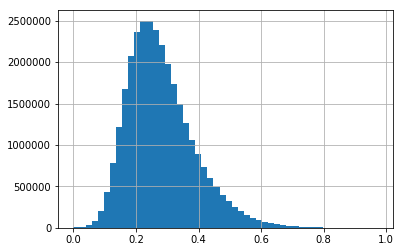

In [22]:
df["sim"].hist(bins=50)

In [97]:
df_sim = df[df["sim"]<=0.03]

In [132]:
len(set(df_sim[1].tolist() + df_sim[2].tolist()))

2104

In [169]:
master = {}

for ind, row in df_sim.iterrows():
    if row[1] in master:
        master[row[1]][row[2]] = row["sim"]
    elif row[2] in master:
        master[row[2]][row[1]] = row["sim"]
    else:
        master[row[1]] = {row[2]: row["sim"]}
        seen[row[2]] = row[1]    

In [177]:
with open("/Users/nicholasjenkins/Documents/duplicates_website/duplicates/master.json", 'w') as f:
    json.dump(master, f)

In [175]:
index = index.reset_index().set_index("GUID")
index["full_path"] = index["path"] + index["ext"]
paths = index["full_path"].to_dict()

In [178]:
with open("/Users/nicholasjenkins/Documents/duplicates_website/duplicates/paths.json", 'w') as f:
    json.dump(paths, f)